In [17]:

import numpy as np
from datetime import date, timedelta
from scipy import stats
import os
import sys
import pandas as pd
from shapely.geometry import Point
import fiona
import matplotlib.pyplot as plt
#import pdfplumber
import geopandas as gpd
import re
import json
import numpy as np
import rioxarray
import rasterio as rio
from geocube.api.core import make_geocube
import os 
import numpy
 
import rasterio as rio
import xarray as xr 
import math

In [64]:
wor_dir="C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model"
os.chdir(wor_dir)

admin_df =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/input/phl_admin3_simpl2.geojson')
wind =xr.open_dataset('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/input/STORM_FIXED_RETURN_PERIODS_WP.nc')
####  admin boundary shape file 
min_lon = math.floor(admin_df.total_bounds[0])
min_lat = math.floor(admin_df.total_bounds[1])
max_lon = math.ceil(admin_df.total_bounds[2])
max_lat = math.ceil(admin_df.total_bounds[3])

### create a new unique identifier with type integer 
admin_df['ind'] = admin_df.apply(lambda row: row.adm2_pcode[2:], axis=1)
admin_df["pcode"] = admin_df.ind.astype(int)


In [117]:
wind_df=[]
for rpt in [20,50,100,200,500]:
    wind_rp100=wind.sel(rp=rpt).drop(['rp'])['mean'].to_dataset(name='wind').rio.write_crs("epsg:4326", inplace=True).rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    wind_rp100=wind_rp100.rename({'lon': 'x','lat': 'y'})
    
    out_grid = make_geocube(
        vector_data=admin_df,
        measurements=["pcode"],
        like=wind_rp100, # ensure the data are on the same grid
       # interpolate_na_method  ='nearest', 
    )

    wind_rp100=wind_rp100.drop('spatial_ref')
    out_grid[f"wind_{rpt}"] = (wind_rp100['wind'].dims, wind_rp100['wind'].values)
    zonal_stats_df = (out_grid.groupby(out_grid.pcode).max(skipna=False).to_dataframe().reset_index())
    zonal_stats_df["placeCode"] = zonal_stats_df.apply(lambda row: "PH" + str(int(row.pcode)).zfill(9), axis=1)
    
    wind_df.append(zonal_stats_df[["placeCode",f"wind_{rpt}"]])
    #wind_=out_grid[f"wind_{rpt}"].to_dataset()
    #f, ax = plt.subplots(figsize=(10, 8))
    #wind_.wind.plot()#legend=True,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
   # ax.set_title(f'windspeed with return period of {rpt}')
   # ax.set_axis_off()
   # admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)#,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
   # plt.show()
wind_df=pd.concat(wind_df, axis=1)
wind_df = wind_df.loc[:,~wind_df.columns.duplicated()]


In [118]:

wind_df

,placeCode,wind_20,wind_50,wind_100,wind_200,wind_500
0,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868
1,PH012900000,37.294643,40.086027,42.067048,43.764174,46.104239
2,PH013300000,37.317018,40.477655,42.489864,44.356190,46.481330
3,PH015500000,38.376795,41.702480,43.870337,45.469847,47.404826
4,PH020900000,39.692123,42.628096,44.342475,45.930999,48.058281
...,...,...,...,...,...,...
80,PH175200000,39.392675,44.283038,46.933352,48.994989,51.633909
81,PH175300000,NaN,41.950686,45.149203,47.755892,50.932082
82,PH175900000,39.582747,44.075568,46.917454,49.294826,51.811026
83,PH184500000,35.711289,40.683659,43.960121,46.709160,49.426155


In [121]:
df_WIND = pd.merge(
    admin_df[["adm2_pcode", "geometry","adm3_pcode"]],
    wind_df,
    how="left",
    left_on="adm2_pcode",
    right_on="placeCode",
)
df_WIND['wind_3se_guest']=df_WIND['wind_50']*1.66*3.6  # conversion to V3 and mph



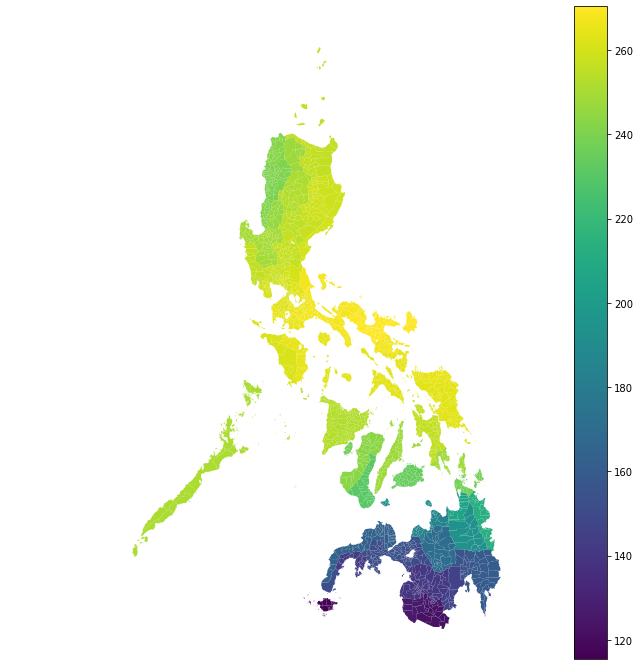

In [122]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
df_WIND.plot(column='wind_3se_guest',ax=ax,legend=True)
leg = ax.get_legend()
#leg.set_bbox_to_anchor((1.15,0.5))
ax.set_axis_off()
plt.show()

### referances
https://library.wmo.int/doc_num.php?explnum_id=290 for conversion of 3second and 10 minutes wind

https://www.nature.com/articles/s41597-020-0381-2 source of windspeed data for different return periods (10 min average)

https://www.pagasa.dost.gov.ph/products-and-services/severe-wind-maps pagassa methedology 


In [123]:
df_WIND

,adm2_pcode,geometry,adm3_pcode,placeCode,wind_20,wind_50,wind_100,wind_200,wind_500,wind_3se_guest
0,PH012800000,"MULTIPOLYGON (((120.94626 18.51158, 120.96915 ...",PH012801000,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868,242.154119
1,PH012800000,"MULTIPOLYGON (((120.59081 18.29526, 120.59192 ...",PH012802000,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868,242.154119
2,PH012800000,"MULTIPOLYGON (((120.47783 17.97744, 120.47814 ...",PH012803000,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868,242.154119
3,PH012800000,"MULTIPOLYGON (((120.79393 18.53475, 120.79537 ...",PH012804000,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868,242.154119
4,PH012800000,"MULTIPOLYGON (((120.56070 18.12259, 120.56127 ...",PH012805000,PH012800000,37.501867,40.521104,42.698779,44.115640,45.943868,242.154119
...,...,...,...,...,...,...,...,...,...,...
1642,PH184600000,"MULTIPOLYGON (((123.16419 9.95278, 123.16998 9...",PH184622000,PH184600000,33.209901,38.613349,42.361211,45.573173,48.707855,230.753371
1643,PH184600000,"MULTIPOLYGON (((123.20764 9.32295, 123.21151 9...",PH184623000,PH184600000,33.209901,38.613349,42.361211,45.573173,48.707855,230.753371
1644,PH184600000,"MULTIPOLYGON (((123.33592 10.38248, 123.33583 ...",PH184624000,PH184600000,33.209901,38.613349,42.361211,45.573173,48.707855,230.753371
1645,PH184600000,"MULTIPOLYGON (((123.17078 9.22988, 123.18679 9...",PH184625000,PH184600000,33.209901,38.613349,42.361211,45.573173,48.707855,230.753371
